In [1]:
!pip install yahoo_finance
!pip install pandas-datareader
!pip install pyramid-arima
!pip install statsmodels

In [2]:
import pandas_datareader.data as web
import datetime
import pandas as pd
import numpy as np
import math
import random
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler

In [3]:
now = datetime.datetime.now()

start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(now.year, now.month, now.day - 1, 23, 59, 59)

In [4]:
# ticker = ['YESBANK.NS']
# BRITANNIA
df_yahoo = web.DataReader('YESBANK.NS', 'yahoo', start, end )
print(df_yahoo.shape)
df_yahoo.head()

(1482, 6)


High         Low  ...      Volume   Adj Close
Date                                ...                        
2015-01-01  154.929993  153.210007  ...   3675025.0  129.212143
2015-01-02  159.160004  154.199997  ...  10627395.0  132.498688
2015-01-05  160.979996  157.960007  ...  14164070.0  132.783005
2015-01-06  157.759995  153.669998  ...  12749005.0  129.061600
2015-01-07  155.199997  150.850006  ...  15567125.0  126.669891

[5 rows x 6 columns]

In [5]:
df_yahoo.tail()

High        Low       Open  Close       Volume  Adj Close
Date                                                                      
2020-12-31  18.150000  17.650000  17.750000  17.85  125361787.0      17.85
2021-01-01  18.450001  17.799999  17.850000  18.00  146080241.0      18.00
2021-01-04  18.600000  17.900000  18.400000  18.00  214860840.0      18.00
2021-01-05  18.250000  17.750000  17.950001  18.00  172429356.0      18.00
2021-01-06  18.400000  17.799999  18.200001  18.00  196835252.0      18.00

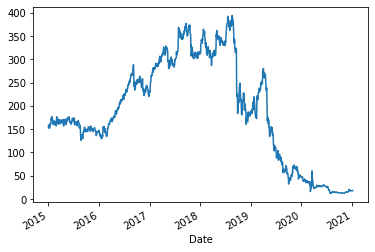

In [6]:
df_yahoo['Close'].plot()
plt.show()

In [7]:
df = df_yahoo
df['Date'] = df_yahoo.index
df.reset_index(drop=True, inplace=True)
df.head()

High         Low        Open  ...      Volume   Adj Close       Date
0  154.929993  153.210007  153.800003  ...   3675025.0  129.212143 2015-01-01
1  159.160004  154.199997  154.600006  ...  10627395.0  132.498688 2015-01-02
2  160.979996  157.960007  159.300003  ...  14164070.0  132.783005 2015-01-05
3  157.759995  153.669998  157.710007  ...  12749005.0  129.061600 2015-01-06
4  155.199997  150.850006  154.000000  ...  15567125.0  126.669891 2015-01-07

[5 rows x 7 columns]

In [8]:
df.shape

(1482, 7)

##Splitting Indexes

In [9]:
sliding_window = 10
train_split = len(df) - sliding_window

# LSTM (Long Short Term Memory)

In [10]:
df_lstm = df[['Date', 'Close']]
df_lstm.head()

Date       Close
0 2015-01-01  154.509995
1 2015-01-02  158.440002
2 2015-01-05  158.779999
3 2015-01-06  154.330002
4 2015-01-07  151.470001

In [11]:
# setting index
new_data = pd.DataFrame(data=df_lstm['Close'], columns=['Close'])
new_data.index = df_lstm['Date']
new_data.head()

Close
Date                  
2015-01-01  154.509995
2015-01-02  158.440002
2015-01-05  158.779999
2015-01-06  154.330002
2015-01-07  151.470001

In [12]:
train = new_data[:train_split]
validation = new_data[train_split:]

In [13]:
train.shape, validation.shape

((1472, 1), (10, 1))

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled_data = scaler.fit_transform(train)

In [15]:
x_train, y_train = [], []
for i in range(sliding_window,train_split):
    x_train.append(train_scaled_data[i-sliding_window:i,0])
    y_train.append(train_scaled_data[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [16]:
x_train.shape, y_train.shape

((1462, 10, 1), (1462,))

In [17]:
inputs = new_data[len(new_data) - len(validation) - sliding_window:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_Val, y_val = [], []
for i in range(sliding_window,inputs.shape[0]):
    X_Val.append(inputs[i-sliding_window:i,0])
    y_val.append(inputs[i, 0])

X_Val, y_val = np.array(X_Val), np.array(y_val)
X_Val = np.reshape(X_Val, (X_Val.shape[0],X_Val.shape[1],1))

In [18]:
# create and fit the LSTM network
tf.keras.backend.clear_session()
model = Sequential()
model.add(LSTM(units=500, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=250))
model.add(Dense(units=200))
model.add(Dense(1))

model.compile(loss='mse', optimizer=Adam(lr=0.001))

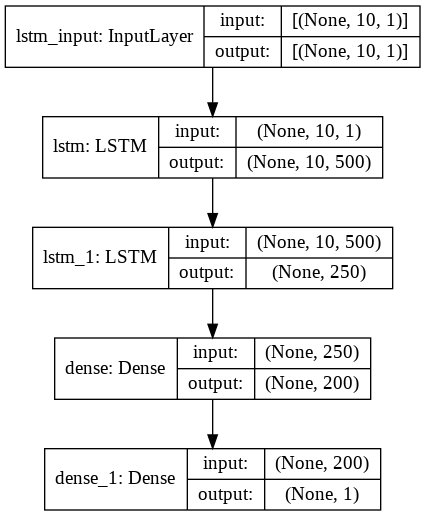

In [19]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [20]:
chk_point_path = '/content/drive/MyDrive/Colab Notebooks/stock_brit.h5'
tb_path = '/content/drive/MyDrive/Colab Notebooks/stock_brit/logs/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [21]:
chk_point = tf.keras.callbacks.ModelCheckpoint(chk_point_path, save_best_only=True, mode='min')
tensor_board = tf.keras.callbacks.TensorBoard(log_dir=tb_path, write_graph=True, \
                                                   write_images=True, update_freq='epoch', \
                                                   histogram_freq=1)

In [22]:
model.fit(x_train, y_train, epochs=500, batch_size=64, validation_data=(X_Val, y_val), callbacks=[chk_point, tensor_board])

Epoch 1/500
23/23 [==============================] - 6s 58ms/step - loss: 0.0659 - val_loss: 0.0018
Epoch 2/500
23/23 [==============================] - 0s 11ms/step - loss: 0.0019 - val_loss: 1.1688e-04
Epoch 3/500
23/23 [==============================] - 0s 8ms/step - loss: 0.0011 - val_loss: 8.8030e-05
Epoch 4/500
23/23 [==============================] - 0s 8ms/step - loss: 8.5454e-04 - val_loss: 1.2079e-06
Epoch 5/500
23/23 [==============================] - 0s 8ms/step - loss: 9.3390e-04 - val_loss: 1.4430e-05
Epoch 6/500
23/23 [==============================] - 0s 8ms/step - loss: 7.5050e-04 - val_loss: 1.7879e-05
Epoch 7/500
23/23 [==============================] - 0s 10ms/step - loss: 9.9985e-04 - val_loss: 2.0530e-05
Epoch 8/500
23/23 [==============================] - 0s 8ms/step - loss: 9.3274e-04 - val_loss: 1.2034e-05
Epoch 9/500
23/23 [==============================] - 0s 8ms/step - loss: 7.6857e-04 - val_loss: 1.2703e-05
Epoch 10/500
23/23 [==============================

In [23]:
closing_price = model.predict(X_Val)
closing_price = scaler.inverse_transform(closing_price)

In [24]:
saved_model = tf.keras.models.load_model(chk_point_path)
best_model_closing_price = saved_model.predict(X_Val)
best_model_closing_price = scaler.inverse_transform(best_model_closing_price)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


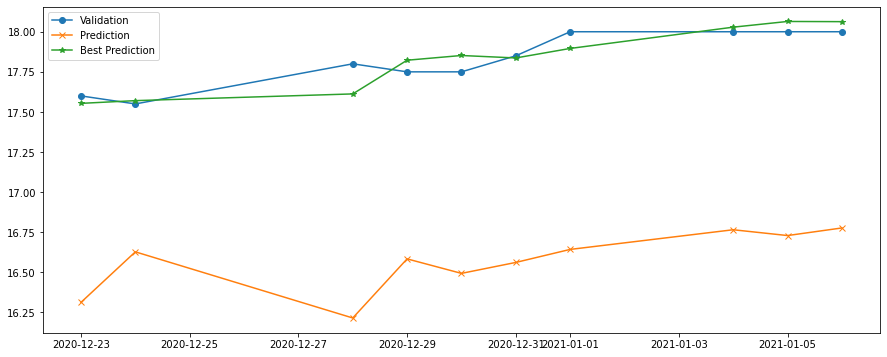

In [25]:
valid = new_data.iloc[train_split:]
valid['Predictions'] = closing_price

valid_best_model = new_data[train_split:]
valid_best_model['Predictions'] = best_model_closing_price

#plt.plot(train['Close'], label='Train')
plt.figure(figsize=(15,6))
plt.plot(valid['Close'], label='Validation', marker='o')
plt.plot(valid['Predictions'], label='Prediction', marker='x')
plt.plot(valid_best_model['Predictions'], label='Best Prediction', marker='*')

plt.legend()
plt.show()

# Future Prediction

In [30]:
future_predict = 365
datelist = pd.date_range(start = (datetime.date.today() + datetime.timedelta(days=1)), periods=future_predict)

In [32]:
best_predicted_values = []
X_test_data = np.array(new_data[-sliding_window:].values)
X_test_data  = scaler.transform(X_test_data)

for i in range(future_predict):

  X_test_data = np.reshape(X_test_data, (1, sliding_window,1))
  closing_price_daily = saved_model.predict(X_test_data)
  closing_price_daily_inversed = scaler.inverse_transform(closing_price_daily)
  best_predicted_values.append(closing_price_daily_inversed.item())

  X_test_data = np.append(X_test_data, closing_price_daily).reshape(-1, 1)
  X_test_data = X_test_data[1:]

best_predicted_df = pd.DataFrame(best_predicted_values, index=datelist, columns=['Predicted_stock_value'])


Predicted_stock_value
2021-12-08              65.392433
2021-12-09              65.700432
2021-12-10              66.010117
2021-12-11              66.321465
2021-12-12              66.634529
2021-12-13              66.949272
2021-12-14              67.265739
2021-12-15              67.583908
2021-12-16              67.903816
2021-12-17              68.225456
2021-12-18              68.548851
2021-12-19              68.873993
2021-12-20              69.200905
2021-12-21              69.529587
2021-12-22              69.860054
2021-12-23              70.192322
2021-12-24              70.526375
2021-12-25              70.862259
2021-12-26              71.199966
2021-12-27              71.539490
2021-12-28              71.880859
2021-12-29              72.224091
2021-12-30              72.569176
2021-12-31              72.916138
2022-01-01              73.264969
2022-01-02              73.615707
2022-01-03              73.968330
2022-01-04              74.322876
2022-01-05              74.679337
2022-01-06              75.037727

In [34]:
best_predicted_df['2021-12-01':'2021-12-31']

Predicted_stock_value
2021-12-01              63.282520
2021-12-02              63.579060
2021-12-03              63.877209
2021-12-04              64.176979
2021-12-05              64.478378
2021-12-06              64.781410
2021-12-07              65.086098
2021-12-08              65.392433
2021-12-09              65.700432
2021-12-10              66.010117
2021-12-11              66.321465
2021-12-12              66.634529
2021-12-13              66.949272
2021-12-14              67.265739
2021-12-15              67.583908
2021-12-16              67.903816
2021-12-17              68.225456
2021-12-18              68.548851
2021-12-19              68.873993
2021-12-20              69.200905
2021-12-21              69.529587
2021-12-22              69.860054
2021-12-23              70.192322
2021-12-24              70.526375
2021-12-25              70.862259
2021-12-26              71.199966
2021-12-27              71.539490
2021-12-28              71.880859
2021-12-29              72.224091
2021-12-30              72.569176
2021-12-31              72.916138

In [28]:
predicted_values = []
X_test_data = np.array(new_data[-sliding_window:].values)
X_test_data  = scaler.transform(X_test_data)

for i in range(future_predict):

  X_test_data = np.reshape(X_test_data, (1, sliding_window,1))
  closing_price_daily = model.predict(X_test_data)
  closing_price_daily_inversed = scaler.inverse_transform(closing_price_daily)
  predicted_values.append(closing_price_daily_inversed.item())

  X_test_data = np.append(X_test_data, closing_price_daily).reshape(-1, 1)
  X_test_data = X_test_data[1:]
  
predicted_df = pd.DataFrame(predicted_values, index=datelist, columns=['Predicted_stock_value'])
predicted_df.tail(10)

Predicted_stock_value
2021-01-27              -0.460743
2021-01-28              -1.193639
2021-01-29              -1.916139
2021-01-30              -2.628183
2021-01-31              -3.329588
2021-02-01              -4.020445
2021-02-02              -4.700810
2021-02-03              -5.370687
2021-02-04              -6.030064
2021-02-05              -6.678988

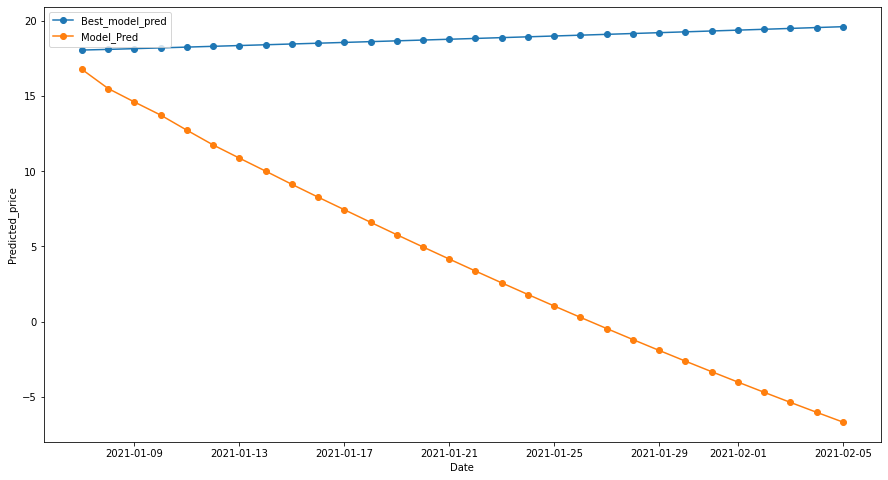

In [29]:
plt.figure(figsize=(15,8))
plt.plot(best_predicted_df, marker='o', label='Best_model_pred')
plt.plot(predicted_df, marker='o', label='Model_Pred')
plt.xlabel('Date')
plt.ylabel('Predicted_price')
plt.legend()

if len(datelist) < 7:
  for x, y in zip(datelist, best_predicted_values):
    label = "{:.2f}".format(y)
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='left')

  for x, y in zip(datelist, predicted_values):
    label = "{:.2f}".format(y)
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='left')

plt.show()

# Future Work

Implement: https://arxiv.org/abs/2009.10819

